In [1]:
import torch

from src.modules import TabNetNoEmbeddings, TabNet, TabNetPretraining
from arguments import (ModelArguments, DataArguments)
from dataset import TabularDataset, TabularDatasetFromHuggingface

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

import PIL
from PIL import Image

from torchvision.transforms.functional import to_pil_image

from datasets import load_dataset

import yaml

#### 시각화를 위한 함수

In [2]:
def Equalize(img: Image) -> Image:
    return PIL.ImageOps.equalize(img)

def Invert(img: Image) -> Image:
    return PIL.ImageOps.invert(img)

#### 모델 불러오기

In [3]:
model_args = ModelArguments
data_args = DataArguments

device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' ) #'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
with open('./src/model/best_model/best_model.yml') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

model = TabNet(
    config['input_dim'],
    config['output_dim'],
    config['n_d'],
    config['n_a'],
    config['n_steps'],
    config['gamma'],
    config['cat_idxs'],
    config['cat_dims'],
    config['cat_emb_dim'],
    config['n_independent'],
    config['n_shared'],
    config['virtual_batch_size'],
    config['momentum'],
    config['epsilon'],
    ).to(device)

In [12]:
model.load_state_dict(torch.load('./src/model/best_model/best_model.pt', map_location=device))

model.eval()
print()

#### 데이터셋 불러오기

In [6]:
data_files = {"test": "test.csv"}
dataset = load_dataset("PDJ107/riot-data", data_files=data_files, revision='cgm_20', use_auth_token=True)

dataset = TabularDatasetFromHuggingface(dataset['test'])

Using custom data configuration PDJ107--riot-data-0e3b3e895212b2de
Reusing dataset csv (/opt/ml/.cache/huggingface/datasets/csv/PDJ107--riot-data-0e3b3e895212b2de/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 57451/57451 [02:11<00:00, 436.56it/s]


#### 주요 피처(메타) 계산

In [8]:
test_dataloader = DataLoader(dataset, batch_size=config['batch_size'], pin_memory=True)

In [30]:
explains = []
for x, label in tqdm(test_dataloader):
    explain, _ = model.forward_masks(x.to(device))
    explains.append(explain.detach().cpu())


100%|██████████| 113/113 [00:24<00:00,  4.63it/s]


In [36]:
len(explains[0][0])

350

In [44]:
M_explains = torch.stack(explains[:-1],dim=0)

In [55]:
M_explains = M_explains.view(-1, 350)

In [61]:
for i in range(100):
    assert torch.equal(M_explains[i], explains[0][i])

In [62]:
t = torch.sum(M_explains, dim=0).view(1,-1)

#### max_num개의 주요 피처 출력

In [63]:
max_num = 20
max_M_explains = [t[0].tolist().index(i) for i in sorted(t[0].tolist(), reverse=True)[:max_num]]

In [64]:
[list(dataset.columns)[i] for i in max_M_explains]

['magicDamageTaken_5_s',
 'visionWardsBoughtInGame_3_s',
 'totalDamageDealtToChampions_5_s',
 'damageDealtToObjectives_9_s',
 'totalTimeSpentDead_3_s',
 'damageDealtToObjectives_2_s',
 'dragonKills_3_s',
 'deaths_6_s',
 'neutralMinionsKilled_9_s',
 'visionScore_3_s',
 'magicDamageDealtToChampions_5_s',
 'totalDamageDealtToChampions_7_s',
 'visionScore_1_s',
 'totalTimeCCDealt_8_s',
 'assists_2_s',
 'goldEarned_9_s',
 'damageDealtToObjectives_1_s',
 'dragonKills_0_s',
 'wardsPlaced_3_s',
 'turretKills_6_s']

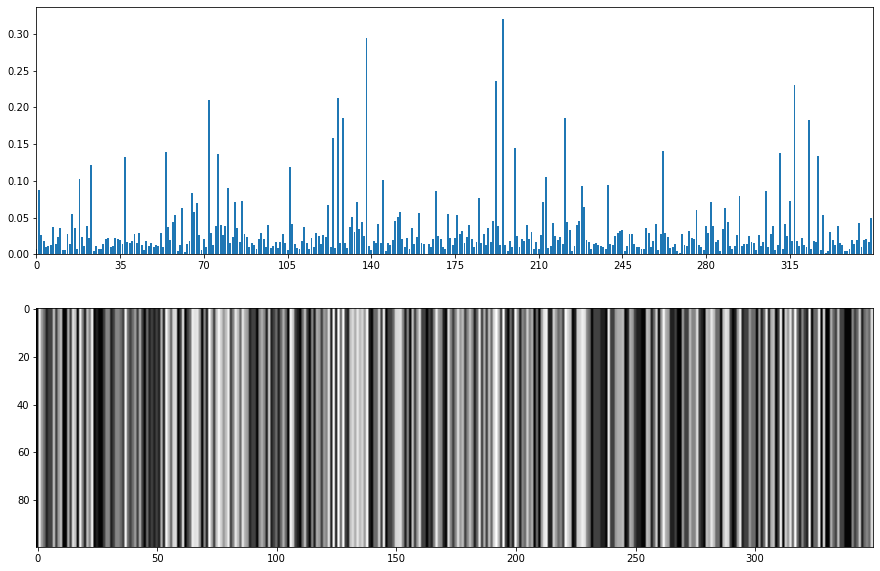

<PIL.Image.Image image mode=L size=350x1 at 0x7F4AB81BF310>


In [65]:
t = torch.sum(M_explains, dim=0).view(1,-1)
t = torch.nn.functional.normalize(t)
t = t
fig, axes = plt.subplots(2, 1, figsize=(15,10))

axes[0].set_xlim(0,350)
axes[0].set_xticks([i*35 for i in range(10)])
axes[0].bar(range(len(t[0])), t[0])

axes[1].imshow(Equalize(to_pil_image(t).resize((350,100))), cmap='gray')
plt.show()
print(to_pil_image(t))